# Intro

数据：不复权价

**修改记录:**

- 20210727: 再进行check一遍个股数据，个股的北向资金持有已经和wind确认过了没问题

- 20210730: 经过验证，个股数据和金工里的数据是一样的，发现了数据不一致的问题：

<font color='red'>我的个股的净北向资金流入算法：当天持股总量\*价格 -  昨日持股总量\*价格 --》__×__</font>

<font color='blue'>晨哥的计算方式：（当天持股总量 -  昨日持股总量）\* 今日价格 --》__√__</font>

但是仍有小部分差距，我算出来的北向资金净流入量始终是大于晨哥一部分，考虑的问题在：
- 到底是用哪一天的价格，目前用的是当天的价格来计算的，考虑是否使用周均价、日均价等

- 20210731: 应该是知道了哪里有问题了，有些股票之前没有北向资金的流入，因此在纵向合并的时候，会被删去

- 20210802: 修改了回测方法，使用周频得change来计算

- 20210803:  股票和wind对了一下，基本一致

- 20210804 - 记录回测数据,这里纠错了，应该用下一个周的收益率来计算涨跌幅

**未来方向**

- 一周的收益是否够？还是可以有办法进一步缩小间隙

# package

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import time
import tushare as ts

import seaborn as sns

In [4]:
# ts.set_token('')
pro = ts.pro_api('')

# 函数

In [14]:
def pivot_data(data,col_pivot,dates_pivot,value):
    dates = pd.unique(data[dates_pivot])
    result = pd.DataFrame(columns=pd.unique(data[col_pivot]))
    result['date'] = ''
    
    for i in dates:

        daily = data[data[dates_pivot] == i]
        data_pivot = daily.groupby(col_pivot)[value].sum()
        
        a = pd.DataFrame(data_pivot).T
        a['date'] = i
        result = pd.concat([result,a])
    return result

def find_top(n,data):
    top_list = pd.DataFrame()
    for i,day in enumerate(data.index):
        top_data = data.iloc[i].sort_values(ascending = False).head(n).index
        top_list[day] = top_data
        
    return top_list

# 原始数据

In [1160]:
data = pd.read_csv('north_data_ori.csv',index_col=0)

data.columns = ['date','code','name','north_holding','ratio','exchange','close','sw_first','sw_second']

data['cashflow'] = data['north_holding']*data['close']

data.info()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1336006 entries, 0 to 1817
Data columns (total 10 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   date           1336006 non-null  int64  
 1   code           1336006 non-null  object 
 2   name           1336006 non-null  object 
 3   north_holding  1336006 non-null  int64  
 4   ratio          1336004 non-null  float64
 5   exchange       1336006 non-null  object 
 6   close          1336006 non-null  float64
 7   sw_first       1336006 non-null  object 
 8   sw_second      1336006 non-null  object 
 9   cashflow       1336006 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 112.1+ MB


## north_data_net_hd (个股北向数据流）

In [1162]:
shares = pd.unique(data['code'])

data_net_hd = pd.DataFrame()
for i in range(len(shares)):
    share_table = data[data['code'] == shares[i]]
    share_table = share_table.sort_values(by='date',ascending=True)
    share_table['net_hd'] = share_table['north_holding'].diff()
    data_net_hd = pd.concat([data_net_hd,share_table])

data_net_hd.head()

读取数据

In [8]:
# data_net_hd.to_csv('north_data_net_hd.csv')

data_net_hd = pd.read_csv('north_data_net_hd.csv',index_col=0)

# 因为进行取了差值，所以有NaN值的存在
data_net_hd.head()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,date,code,name,north_holding,ratio,exchange,close,sw_first,sw_second,cashflow,net_hd
121,20181008,600000.SH,浦发银行,270675558,0.96,SH,10.16,801780.SI,801192.SI,2.750064e+09,NaN
6,20181009,600000.SH,浦发银行,265463462,0.94,SH,10.15,801780.SI,801192.SI,2.694454e+09,-5212096.0
408,20181010,600000.SH,浦发银行,265280261,0.94,SH,10.17,801780.SI,801192.SI,2.697900e+09,-183201.0
667,20181011,600000.SH,浦发银行,264101214,0.93,SH,9.80,801780.SI,801192.SI,2.588192e+09,-1179047.0
77,20181012,600000.SH,浦发银行,265768273,0.94,SH,10.03,801780.SI,801192.SI,2.665656e+09,1667059.0


In [9]:
data_net_hd['net_cf'] = data_net_hd['net_hd']* data_net_hd['close']

In [10]:
# 去除NaN值
data = data_net_hd.dropna()
data.head()

,date,code,name,north_holding,ratio,exchange,close,sw_first,sw_second,cashflow,net_hd,net_cf
6,20181009,600000.SH,浦发银行,265463462,0.94,SH,10.15,801780.SI,801192.SI,2.694454e+09,-5212096.0,-52902774.40
408,20181010,600000.SH,浦发银行,265280261,0.94,SH,10.17,801780.SI,801192.SI,2.697900e+09,-183201.0,-1863154.17
667,20181011,600000.SH,浦发银行,264101214,0.93,SH,9.80,801780.SI,801192.SI,2.588192e+09,-1179047.0,-11554660.60
77,20181012,600000.SH,浦发银行,265768273,0.94,SH,10.03,801780.SI,801192.SI,2.665656e+09,1667059.0,16720601.77
217,20181015,600000.SH,浦发银行,265886720,0.94,SH,10.03,801780.SI,801192.SI,2.666844e+09,118447.0,1188023.41


## share_pivot (周、日，个股的pivot）

In [379]:
# 创建一个全日期的空序列
share_pivot = pd.DataFrame(pd.unique(data['date']), columns={'date'})

shares = pd.unique(data['code'])

for share in shares:
    share_net_cf = data[data['code'] == share][['date','net_cf']].sort_values(by = 'date',ascending=True)

    share_net_cf = share_net_cf.rename(columns={'net_cf': share})

    share_pivot = share_pivot.merge(share_net_cf,how = 'outer',on = 'date')
    if share_pivot.shape[1] % 500 == 0:
        print(share_pivot.shape[1])

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300


In [384]:
share_pivot = share_pivot.fillna(0)

# share_pivot = pivot_data(data,'code','date','net_cf')

share_pivot['date'] = pd.to_datetime(share_pivot['date'],format= "%Y%m%d")

share_pivot =  share_pivot.set_index('date',drop = True)

# share_pivot.to_csv('share_pivot.csv')

读取处理后的个股净流入透视表

In [20]:
share_pivot = pd.read_csv('share_pivot.csv')

share_pivot['date'] = pd.to_datetime(share_pivot['date'],format= "%Y-%m-%d")

share_pivot =  share_pivot.set_index('date',drop = True)

In [21]:
share_pivot_w = share_pivot.resample("W-FRI").sum()
# 这个数据和北向安信里对过了，相差一点点

share_pivot_w.head()

,600000.SH,600004.SH,600006.SH,600007.SH,600008.SH,600009.SH,600010.SH,600011.SH,600012.SH,600015.SH,...,300004.SZ,002107.SZ,002184.SZ,002189.SZ,000922.SZ,000428.SZ,002090.SZ,002278.SZ,002282.SZ,300512.SZ
date,,,,,,,,,,,,,,,,,,,,,
2018-10-12,-4.959999e+07,-31643431.40,-379813.74,4615394.79,5398591.10,-3.530531e+08,10991939.56,18292655.82,-4884009.14,41491486.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-19,4.195089e+07,41830271.87,941660.83,-43698.60,4462120.40,-5.906418e+07,1794054.00,3591751.35,4519960.76,17510079.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-26,2.008834e+08,10782286.26,282043.40,10819761.50,6745594.67,-3.276465e+08,320310.00,-7497681.70,3925957.18,71903.88,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-11-02,4.956911e+08,34766967.39,6701282.33,2721416.19,10678283.55,2.338111e+07,22866565.81,-16644664.63,7213461.58,1255068.13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-102.6,0.0
2018-11-09,6.939665e+06,-10670225.16,967636.76,3061307.00,4003642.01,2.965304e+08,499296.42,14556658.94,9058133.19,-22071803.63,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## data_sw_first（申万一级行业的现金流）

In [15]:
sw_first = pivot_data(data,'sw_first','date','net_cf')

# sw_first = sw_first.pct_change()
# sw_first = sw_first.reset_index(drop=True)
# sw_first = sw_first.drop(index=0,axis=1)
# sw_first = sw_first.reset_index(drop=True)

sw_first['date'] = pd.to_datetime(sw_first['date'],format='%Y%m%d')
sw_first = sw_first.set_index('date',drop=True)

In [16]:
sw_first

,801780.SI,801170.SI,801880.SI,801180.SI,801160.SI,801040.SI,801030.SI,801790.SI,801890.SI,801760.SI,...,801230.SI,801730.SI,801750.SI,801010.SI,801080.SI,801050.SI,801020.SI,801140.SI,801710.SI,801130.SI
date,,,,,,,,,,,,,,,,,,,,,
2018-10-09,-7.067728e+08,-3.241759e+08,5.618852e+05,-1.321069e+08,1.047806e+07,5.733443e+07,-4.491502e+07,-7.566254e+08,3.363311e+06,2.221756e+07,...,5.221618e+06,-2.681321e+07,4.488184e+07,1.292863e+07,-6.626737e+08,1.105261e+08,3.208209e+07,8.473035e+06,7.836731e+07,-4531704.68
2018-10-10,-2.621146e+08,-7.481000e+06,-1.447550e+08,-6.954374e+07,3.831757e+07,1.004759e+08,-9.293346e+07,-8.353917e+07,1.047005e+08,2.752721e+06,...,1.352983e+06,-5.628879e+07,1.477352e+08,-1.087531e+07,-2.210062e+08,-8.022262e+07,-1.265614e+07,-3.201953e+07,-5.219074e+07,-3626722.68
2018-10-11,-2.895923e+08,-1.584117e+08,-1.527036e+08,6.118581e+07,-3.782244e+07,-4.134589e+07,-8.909303e+07,-7.972571e+08,-6.234695e+07,-5.820272e+07,...,4.300386e+06,7.254121e+07,3.744648e+07,8.493642e+07,-4.563145e+08,4.954797e+07,4.546498e+07,-1.024439e+08,1.417029e+07,-19376852.47
2018-10-12,3.389172e+08,1.927379e+07,-1.000756e+08,4.691887e+07,-4.801431e+07,5.459507e+07,-1.305613e+08,3.822852e+07,2.431358e+07,1.774807e+08,...,2.473548e+06,-1.279607e+07,5.541950e+07,2.321703e+07,-6.147538e+07,-2.519642e+07,1.854990e+07,-1.057246e+07,1.916134e+08,1745105.35
2018-10-15,-2.243421e+08,-2.849179e+07,-1.764305e+08,2.477304e+08,1.402464e+07,-4.315131e+07,-7.104379e+07,-2.189890e+08,1.125992e+08,1.499693e+08,...,2.552795e+06,-3.632152e+07,1.030204e+08,1.173701e+07,-1.312349e+08,7.893714e+07,-1.517940e+08,-7.588119e+07,9.899812e+07,-14739533.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-08,-9.529881e+08,-5.543784e+08,-1.338084e+08,-1.461866e+08,-9.802882e+06,-2.451264e+08,-1.404280e+09,-4.226767e+08,1.916487e+08,-2.944964e+07,...,-1.920941e+07,1.148084e+08,5.476010e+08,-1.011131e+08,-4.472353e+08,4.826933e+08,5.462074e+07,2.526002e+07,-3.291435e+08,-6866540.42
2021-07-09,-5.038978e+08,3.767714e+08,2.387436e+08,-1.316594e+08,1.959300e+08,2.773811e+08,-2.260218e+08,-4.749631e+08,-9.966285e+07,3.432552e+07,...,-4.922288e+07,-1.322561e+09,3.583110e+08,6.332039e+07,-2.542612e+08,-2.967679e+08,4.081712e+08,2.636788e+08,3.654882e+07,10726366.40
2021-07-12,-7.664176e+08,3.116268e+08,3.705252e+08,-4.510735e+08,-1.328587e+08,-9.759658e+07,-6.071895e+08,3.860356e+08,-1.141373e+08,1.776839e+08,...,-1.071903e+08,-1.972840e+09,1.469848e+09,-7.281312e+07,-1.473250e+08,-4.321500e+06,-1.562462e+08,1.697228e+08,9.433689e+07,-6813726.43


In [17]:
# transfer the daily into weekly
sw_first_w = sw_first.resample("W-FRI").sum()

In [18]:
sw_first_w.head()

,801780.SI,801170.SI,801880.SI,801180.SI,801160.SI,801040.SI,801030.SI,801790.SI,801890.SI,801760.SI,...,801230.SI,801730.SI,801750.SI,801010.SI,801080.SI,801050.SI,801020.SI,801140.SI,801710.SI,801130.SI
date,,,,,,,,,,,,,,,,,,,,,
2018-10-12,-9.195626e+08,-4.707949e+08,-3.969723e+08,-9.354596e+07,-3.704113e+07,1.710595e+08,-3.575028e+08,-1.599193e+09,7.003040e+07,1.442483e+08,...,13348535.38,-2.335686e+07,2.854830e+08,1.102068e+08,-1.401470e+09,5.465506e+07,8.344082e+07,-1.365629e+08,2.319603e+08,-25790174.48
2018-10-19,1.289755e+09,3.041836e+07,-1.769212e+08,1.155241e+09,1.962982e+08,1.700954e+08,-1.237586e+08,4.472766e+08,1.106269e+08,3.166293e+08,...,6692984.11,8.116365e+07,3.673443e+08,2.100471e+08,-2.224356e+07,4.659636e+08,1.665436e+08,-5.952582e+07,4.742754e+08,2323432.68
2018-10-26,1.780841e+09,-2.130770e+08,-4.151056e+08,4.791840e+08,1.416015e+07,2.604586e+08,-5.205488e+08,7.528820e+08,4.655659e+07,4.826241e+07,...,3720119.32,-1.683577e+07,-6.726635e+08,2.348874e+08,-1.038057e+09,3.569805e+08,1.548995e+08,-1.344293e+08,-1.848193e+09,6323594.97
2018-11-02,6.884396e+09,5.598122e+08,-2.853948e+08,1.876847e+09,-6.843522e+07,-1.063425e+07,5.564843e+08,5.891519e+09,3.349020e+08,1.172453e+08,...,-1138459.61,4.657370e+08,1.517237e+08,1.037361e+08,1.765665e+09,-8.601319e+07,3.179774e+08,-3.731511e+07,1.462406e+09,-30786778.44
2018-11-09,2.416400e+08,7.978399e+08,-6.055948e+08,-1.511399e+08,1.223300e+08,3.006634e+08,1.710111e+08,1.448372e+09,8.984376e+07,-1.951645e+08,...,28733783.64,2.749972e+08,-3.703437e+08,7.419197e+07,-6.335843e+08,-2.193399e+07,-3.938372e+07,-4.358879e+07,8.226947e+08,-2435926.10


In [19]:
# sw_first_w.to_csv('data_sw_first_w.csv')
# sw_first_w = pd.read_csv('data_sw_first_w.csv')

# 查找top n个流入行业

In [1173]:
top_industry = 2

In [1174]:
industry_code_w = find_top(top_industry,sw_first_w)

In [1175]:
industry_code_w

,2018-10-12,2018-10-19,2018-10-26,2018-11-02,2018-11-09,2018-11-16,2018-11-23,2018-11-30,2018-12-07,2018-12-14,...,2021-05-14,2021-05-21,2021-05-28,2021-06-04,2021-06-11,2021-06-18,2021-06-25,2021-07-02,2021-07-09,2021-07-16
0,801110.SI,801780.SI,801780.SI,801120.SI,801120.SI,801120.SI,801120.SI,801780.SI,801780.SI,801110.SI,...,801120.SI,801120.SI,801790.SI,801730.SI,801150.SI,801080.SI,801730.SI,801880.SI,801120.SI,801170.SI
1,801750.SI,801180.SI,801790.SI,801780.SI,801790.SI,801150.SI,801150.SI,801120.SI,801120.SI,801180.SI,...,801780.SI,801110.SI,801120.SI,801890.SI,801730.SI,801750.SI,801150.SI,801750.SI,801050.SI,801750.SI


# 查找top n 个流入股票

In [ ]:
top_share = 2

In [1176]:
share_code = pd.DataFrame()

for each_day in range(industry_code_w.shape[1]):

    share_code_w = pd.DataFrame()

    for each_industry in industry_code_w.iloc[:,each_day]:

        #     获取分类的成份股
        industry_share = pd.unique(data[data['sw_first'] == each_industry]['code'])

        #     每个行业按照北向现金流净流入选出top n个股票
        share = share_pivot_w.loc[industry_code_w.columns[each_day],industry_share].sort_values(ascending = False).index[:top_share]

        share = pd.DataFrame(share,columns=[industry_code_w.columns[each_day]])

        
        share_code_w = pd.concat([share_code_w,share],axis = 0)
    share_code = pd.concat([share_code,share_code_w],axis = 1)
    if each_day % 20 == 0:
        print(each_day)

In [1200]:
share_code

,2018-10-12,2018-10-19,2018-10-26,2018-11-02,2018-11-09,2018-11-16,2018-11-23,2018-11-30,2018-12-07,2018-12-14,...,2021-05-14,2021-05-21,2021-05-28,2021-06-04,2021-06-11,2021-06-18,2021-06-25,2021-07-02,2021-07-09,2021-07-16
0,000651.SZ,600036.SH,600036.SH,600519.SH,600519.SH,600519.SH,000858.SZ,600036.SH,600036.SH,000333.SZ,...,000858.SZ,603288.SH,300059.SZ,300124.SZ,600276.SH,002475.SZ,601012.SH,000625.SZ,600809.SH,601919.SH
1,002032.SZ,601166.SH,600000.SH,000858.SZ,000858.SZ,000858.SZ,002304.SZ,601166.SH,601166.SH,000651.SZ,...,600519.SH,600519.SH,601318.SH,600438.SH,603259.SH,300661.SZ,600406.SH,601689.SH,000858.SZ,002352.SZ
0,600271.SH,000002.SZ,600030.SH,600036.SH,601318.SH,600276.SH,600276.SH,600519.SH,600519.SH,600340.SH,...,601166.SH,000333.SZ,600519.SH,300450.SZ,601012.SH,002230.SZ,300015.SZ,600570.SH,600111.SH,002230.SZ
1,002410.SZ,600606.SH,601318.SH,601166.SH,600837.SH,300015.SZ,300015.SZ,000858.SZ,000858.SZ,002146.SZ,...,601169.SH,000651.SZ,000858.SZ,300724.SZ,300274.SZ,002153.SZ,300760.SZ,300253.SZ,002460.SZ,002439.SZ


# 回测

## 回测（矩阵法） 20210803

In [1]:
# ret_mat = share_code.copy()

# error_code = []
# for day in range(1,share_code.shape[1]):
#     start_date = pd.to_datetime(share_code.columns[day-1]).strftime("%Y%m%d")
#     end_date = pd.to_datetime(share_code.columns[day]).strftime("%Y%m%d")
#     for share in range(share_code.shape[0]):
#         ts_code = share_code.iloc[share,day]
#         df = ts.pro_bar(ts_code=ts_code, adj='qfq', freq = 'W',start_date=start_date, end_date=end_date)
#         if (not pd.DataFrame(df).empty) and df.shape[0] == 2:
#             ret_mat.iloc[share,day] = df.sort_values(by = 'trade_date',ascending = False)['pct_chg'][0]
#         else:
#             ret_mat.iloc[share,day] = 0
            
#     if day % 20 == 0:
#         print(share_code.columns[day])

# ret_mat

# share_code

# # ret_mat.to_csv('ret_mat.csv')
# # ret_mat = pd.read_csv('ret_mat.csv',index_col=0)

# ret_mat = ret_mat.iloc[:,1:]

# # 换算成百分数
# ret_mat = ret_mat* 0.01
# # 平均权重
# ret_mat = ret_mat*0.2
# # 计算各个的收益率
# ret = (ret_mat.sum(axis = 0)+1)

# week_ret = [ret[0]]

# for i in range(1,ret.shape[0]):
#     week_ret.append(ret[i]*week_ret[-1])

# ret_year = week_ret[-1] **(52/173) - 1

# std_year = ret.std()

# ax = plt.figure(figsize=(18,8))
# plt.plot(week_ret)
# plt.plot(ret.values)
# plt.title('top 5 industry and top 1 share')
# plt.show()
# ax.savefig('回测图/前五个行业每个行业第一名的收益率.jpg')

## 回测（个股法） 20210701

In [754]:
# def pd_ret(pro,codes,start_date,end_date,cols):

#     price_buy = pro.daily(ts_code=codes, trade_date=start_date)[cols]
#     price_sell = pro.daily(ts_code=codes, trade_date=end_date)[cols]

#     ret = price_buy.merge(price_sell,on='ts_code',how = 'inner')
#     ret['earning'] = ret['close_y'] - ret['close_x']
#     ret['earning_pct'] = ret['close_y']/ret['close_x']-1
    
#     return ret,price_buy

# def earning_one(price_buy,ret):
#     # 按照每股1手买入
#     weight = price_buy['close']/price_buy['close'].sum()
#     weight = weight.to_numpy().reshape(-1,1)

#     # 计算收益
#     ret_pct = ret['earning_pct'].to_numpy().reshape(-1,1)
#     earning = np.dot(weight.T,ret_pct)
#     return earning[0][0]

# def earning_equal(ret):
#     # 同权重
#     weight = np.ones((len(ret),1))/len(ret)
    
#     # 计算收益
#     ret_pct = ret['earning_pct'].to_numpy().reshape(-1,1)
    
#     earning = np.dot(weight.T,ret_pct)
#     return earning[0][0]

# cols = ['ts_code','trade_date','close']
# return_all = pd.DataFrame()


# for i,day in enumerate(share_code.columns):
#     codes = share_code.iloc[:,i].str.cat(sep=',')
#     start_date = pd.to_datetime(share_code.columns[i]).strftime("%Y%m%d")
#     end_date = (pd.to_datetime(share_code.columns[i])+pd.Timedelta(value=1,unit='W')).strftime("%Y%m%d")

#     price_buy = pro.daily(ts_code=codes, trade_date=start_date)[cols]
#     price_sell = pro.daily(ts_code=codes, trade_date=end_date)[cols]
    
# #     调节接口，避免暂停
#     time.sleep(1)
    
    
# #     循环计算日收益
#     days = np.arange(pd.to_datetime(start_date),pd.to_datetime(end_date), dtype='datetime64[D]')
#     date = []
#     ret_daily = []
    
#     for j in range(len(days)-1):
#         s_date = pd.to_datetime(days[j]).strftime('%Y%m%d')
#         e_date = pd.to_datetime(days[j+1]).strftime('%Y%m%d')
#         ret,price_buy = pd_ret(pro,codes,s_date,e_date,cols)
        
# #     调节接口，避免暂停
#         time.sleep(1)
    
#         if ret.empty:
#             pass
#         else:
#             earning = earning_equal(ret)  # 相同权重
# #             earning = earning_one(price_buy,ret)   #每股均1手
#             date.append(s_date)
#             ret_daily.append(earning)

#     daily_ret = pd.DataFrame(date,columns=['date'])
#     daily_ret['daily_pct'] = ret_daily
#     return_all = pd.concat([return_all,daily_ret])
    
        
#     print(day)

# return_all.to_csv('return_all.csv')

# return_all.head(50)

# return_all = return_all.reset_index(drop=True)

# acc_ret = [1]
# for i in range(len(return_all)):
#     a = (float(return_all['daily_pct'][i])+1)*acc_ret[-1]
#     acc_ret.append(a)

# return_all['acc_ret'] = acc_ret[1:]

# return_all['date'] = pd.to_datetime(return_all['date'])

# return_all = return_all.set_index('date',drop=True)

# plt.figure(figsize=(15,10))
# plt.plot(return_all['acc_ret'])
# plt.show()

# 参数选择

## Package and function

In [1]:
import pandas as pd
import tushare as ts
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pro = ts.pro_api('99c7c9993308aff8f48779f55cea10c28cb7174c0fa5e1b2b51a88b5')

In [3]:
def find_top(n,data):
    top_list = pd.DataFrame()
    for i,day in enumerate(data.index):
        top_data = data.iloc[i].sort_values(ascending = False).head(n).index
        top_list[day] = top_data
        
    return top_list

def find_top2(top_index,data):
    top_list = pd.DataFrame()
    for i,day in enumerate(data.index):
        top_data = data.iloc[i].sort_values(ascending = False).iloc[top_index].index
        top_list[day] = top_data
        
    return top_list

## 数据导入

### 申万周频行业的北向净流入数据透视表

In [5]:
sw_first_w = pd.read_csv('data_sw_first_w.csv',index_col=0)

### 原始数据表北向净流入

In [6]:
data = pd.read_csv('north_data_net_hd.csv',index_col=0)

# 因为进行取了差值，所以有NaN值的存在
data['net_cf'] = data['net_hd']* data['close']

# 去除NaN值
data = data.dropna()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### 股票北向净流入数据透视表

In [7]:
share_pivot = pd.read_csv('share_pivot.csv')
share_pivot['date'] = pd.to_datetime(share_pivot['date'],format= "%Y-%m-%d")
share_pivot =  share_pivot.set_index('date',drop = True)
share_pivot_w = share_pivot.resample("W-FRI").sum()

## 参数选股

### 数据处理

In [8]:
# 这里有两种方式进行选股，一种是直接用head的形式挑选前几名，另一种是用index的方式来进行选取特定排名的行业、股票
top_share = 5
top_industry = 5

top_index_industry = [0,2]
top_index_share = [0,1]

In [9]:
# 按照位置索引
# industry_code_w = find_top2(top_index_industry,sw_first_w)

# 按照前几名进行索引
industry_code_w = find_top(top_industry,sw_first_w)
industry_code_w

,2018-10-12,2018-10-19,2018-10-26,2018-11-02,2018-11-09,2018-11-16,2018-11-23,2018-11-30,2018-12-07,2018-12-14,...,2021-05-14,2021-05-21,2021-05-28,2021-06-04,2021-06-11,2021-06-18,2021-06-25,2021-07-02,2021-07-09,2021-07-16
0,801110.SI,801780.SI,801780.SI,801120.SI,801120.SI,801120.SI,801120.SI,801780.SI,801780.SI,801110.SI,...,801120.SI,801120.SI,801790.SI,801730.SI,801150.SI,801080.SI,801730.SI,801880.SI,801120.SI,801170.SI
1,801750.SI,801180.SI,801790.SI,801780.SI,801790.SI,801150.SI,801150.SI,801120.SI,801120.SI,801180.SI,...,801780.SI,801110.SI,801120.SI,801890.SI,801730.SI,801750.SI,801150.SI,801750.SI,801050.SI,801750.SI
2,801770.SI,801710.SI,801180.SI,801790.SI,801150.SI,801780.SI,801170.SI,801790.SI,801790.SI,801170.SI,...,801010.SI,801150.SI,801780.SI,801010.SI,801030.SI,801010.SI,801080.SI,801080.SI,801750.SI,801770.SI
3,801710.SI,801050.SI,801210.SI,801110.SI,801710.SI,801160.SI,801080.SI,801150.SI,801170.SI,801150.SI,...,801710.SI,801030.SI,801150.SI,801030.SI,801780.SI,801890.SI,801790.SI,801110.SI,801740.SI,801710.SI
4,801040.SI,801790.SI,801050.SI,801150.SI,801170.SI,801170.SI,801730.SI,801030.SI,801180.SI,801780.SI,...,801210.SI,801780.SI,801730.SI,801080.SI,801170.SI,801140.SI,801780.SI,801050.SI,801140.SI,801050.SI


In [83]:
# 按照排名来进行计算的
share_code = pd.DataFrame()

for each_day in range(industry_code_w.shape[1]):

    share_code_w = pd.DataFrame()

    for each_industry in industry_code_w.iloc[:,each_day]:

        #     获取分类的成份股
        industry_share = pd.unique(data[data['sw_first'] == each_industry]['code'])

        #     每个行业按照北向现金流净流入选出top n个股票
        share = share_pivot_w.loc[industry_code_w.columns[each_day],industry_share].sort_values(ascending = False).iloc[:top_share].index

        share = pd.DataFrame(share,columns=[industry_code_w.columns[each_day]])

        
        share_code_w = pd.concat([share_code_w,share],axis = 0)
    share_code = pd.concat([share_code,share_code_w],axis = 1)
    if each_day % 20 == 0:
        
        print(each_day)

0
20
40
60
80
100
120
140


In [85]:
import time

In [157]:
# 以下是按照股票提取收益率

ret_mat = share_code.copy()

error_code = []
for day in range(13,share_code.shape[1]-1):
    start_date = pd.to_datetime(share_code.columns[day]).strftime("%Y%m%d")
    end_date = pd.to_datetime(share_code.columns[day+1]).strftime("%Y%m%d")
    for share in range(share_code.shape[0]):
        ts_code = share_code.iloc[share,day]
        df = ts.pro_bar(ts_code=ts_code, adj='qfq', freq = 'W',start_date=start_date, end_date=end_date)
#         time.sleep(1)
        if (not pd.DataFrame(df).empty) and df.shape[0] == 2:
            ret_mat.iloc[share,day] = df.sort_values(by = 'trade_date',ascending = False)['pct_chg'][0]
        else:
            ret_mat.iloc[share,day] = 0
            
    if day % 10 == 0:
        time.sleep(30)
        pro = ts.pro_api('99c7c9993308aff8f48779f55cea10c28cb7174c0fa5e1b2b51a88b5')
        print(share_code.columns[day])

2019-03-01
2019-05-10
2019-07-19
2019-09-27
2019-12-06
2020-02-14
2020-04-24
2020-07-03
2020-09-11
2020-11-20
2021-01-29
2021-04-09
2021-06-18


### 参数优化

In [48]:
# ret_mat.to_csv('return_mat.csv')
ret_mat = pd.read_csv('return_mat.csv',index_col=0)

ret_mat = ret_mat.iloc[:,:-1]

ret_mat = ret_mat*0.01

ret_mat

,2018-10-12,2018-10-19,2018-10-26,2018-11-02,2018-11-09,2018-11-16,2018-11-23,2018-11-30,2018-12-07,2018-12-14,...,2021-05-07,2021-05-14,2021-05-21,2021-05-28,2021-06-04,2021-06-11,2021-06-18,2021-06-25,2021-07-02,2021-07-09
0,-0.001809,0.013352,0.024662,-0.063177,-0.003559,-0.005536,0.047381,0.001051,-0.008747,-0.046038,...,0.014128,0.033449,0.032221,-0.009262,0.000656,-0.020833,0.182344,-0.040622,0.161594,0.168645
1,0.019181,0.030381,0.023810,-0.068542,0.013597,-0.013218,0.049005,0.005646,-0.014972,-0.033753,...,0.022727,0.016046,0.092013,-0.029053,0.015975,-0.041227,-0.003818,-0.006706,0.043528,0.038312
2,-0.078261,0.042980,0.027604,-0.057012,0.027778,-0.049782,0.016205,-0.007722,0.000000,-0.061856,...,0.046602,0.066445,0.068442,-0.115837,0.029187,-0.017079,-0.070424,0.091048,-0.056245,0.023025
3,-0.007909,0.035026,0.008460,-0.031343,0.029213,-0.059804,0.014545,0.016807,-0.003017,-0.065410,...,0.004057,0.018139,0.009821,-0.024446,-0.046358,-0.029809,0.108615,0.037563,0.089155,-0.008220
4,-0.017949,0.016181,-0.008050,-0.049512,0.006425,-0.001489,0.019140,0.003752,-0.010700,-0.068352,...,0.045599,0.039144,0.065981,-0.029790,0.145038,-0.022005,0.082278,-0.048873,-0.010913,0.026281
0,0.014286,0.104360,0.053910,-0.057039,0.009749,0.005136,0.045026,0.038938,0.010153,-0.078086,...,-0.057198,-0.067915,0.012017,0.009641,0.099671,-0.027123,-0.040770,0.010358,-0.074213,0.141414
1,0.052255,0.091071,0.027617,-0.042735,0.073355,-0.023826,0.038251,0.015461,-0.003947,-0.060920,...,-0.092787,-0.012121,-0.008870,-0.005049,0.010283,0.016553,-0.042908,-0.037552,-0.029940,0.087601
2,-0.014698,0.091275,0.121673,-0.026846,-0.006061,0.033333,-0.019465,-0.033991,0.051375,-0.085530,...,-0.002273,-0.015824,0.018931,0.059240,0.049499,0.027595,-0.003952,-0.009898,0.098878,-0.013807
3,0.076735,0.066231,0.071901,-0.032864,0.126418,-0.063312,-0.027055,0.044343,0.013847,-0.080769,...,-0.081812,-0.003040,0.040066,-0.024162,-0.047767,0.013687,-0.011232,0.009179,0.007435,0.034996
4,0.080671,0.085044,-0.008635,-0.038462,0.039007,-0.040976,0.013013,0.039268,0.011729,-0.001613,...,0.046431,0.007825,-0.029809,0.018616,-0.016522,0.040044,-0.057708,-0.052585,0.040804,0.072138


以下是基于上面的数据进行的各种分析

In [49]:
# 这一步的代码是用来随机选取长度的收益率，防止overfitting
ret_mat = ret_mat.iloc[:,:-30]

ret_mat

,2018-10-12,2018-10-19,2018-10-26,2018-11-02,2018-11-09,2018-11-16,2018-11-23,2018-11-30,2018-12-07,2018-12-14,...,2020-10-09,2020-10-16,2020-10-23,2020-10-30,2020-11-06,2020-11-13,2020-11-20,2020-11-27,2020-12-04,2020-12-11
0,-0.001809,0.013352,0.024662,-0.063177,-0.003559,-0.005536,0.047381,0.001051,-0.008747,-0.046038,...,-0.049967,-0.018442,0.112545,0.058201,-0.007185,0.048992,0.033068,0.023196,0.069427,0.066621
1,0.019181,0.030381,0.023810,-0.068542,0.013597,-0.013218,0.049005,0.005646,-0.014972,-0.033753,...,-0.059837,0.001945,-0.028949,0.107514,-0.103524,0.077852,-0.078341,0.062570,-0.057920,0.087898
2,-0.078261,0.042980,0.027604,-0.057012,0.027778,-0.049782,0.016205,-0.007722,0.000000,-0.061856,...,-0.025455,-0.001055,0.236364,0.089676,-0.018126,0.062587,0.046455,0.010674,-0.035014,0.061018
3,-0.007909,0.035026,0.008460,-0.031343,0.029213,-0.059804,0.014545,0.016807,-0.003017,-0.065410,...,-0.053846,0.065458,-0.032573,0.000602,-0.009524,0.305913,0.086279,0.008056,-0.051706,0.098253
4,-0.017949,0.016181,-0.008050,-0.049512,0.006425,-0.001489,0.019140,0.003752,-0.010700,-0.068352,...,0.008340,-0.051208,-0.012296,0.065968,0.007020,0.052277,-0.078671,-0.002640,-0.025968,0.155065
0,0.014286,0.104360,0.053910,-0.057039,0.009749,0.005136,0.045026,0.038938,0.010153,-0.078086,...,-0.069268,0.036199,-0.067904,0.067069,-0.053853,0.014547,0.039019,0.031901,0.051415,0.016245
1,0.052255,0.091071,0.027617,-0.042735,0.073355,-0.023826,0.038251,0.015461,-0.003947,-0.060920,...,0.014364,0.060234,-0.062573,-0.006197,0.022901,0.006977,0.111879,-0.083663,0.067436,0.019628
2,-0.014698,0.091275,0.121673,-0.026846,-0.006061,0.033333,-0.019465,-0.033991,0.051375,-0.085530,...,-0.048185,0.024631,-0.071854,0.010674,0.025000,-0.039064,0.036608,0.001705,0.151064,0.017949
3,0.076735,0.066231,0.071901,-0.032864,0.126418,-0.063312,-0.027055,0.044343,0.013847,-0.080769,...,-0.005932,0.038549,-0.072727,0.015898,-0.028759,-0.056209,0.027370,-0.012729,-0.045822,-0.021870
4,0.080671,0.085044,-0.008635,-0.038462,0.039007,-0.040976,0.013013,0.039268,0.011729,-0.001613,...,-0.012869,0.014028,-0.052067,0.001932,0.122961,0.002775,0.025285,-0.004599,-0.052936,0.011933


In [50]:
# 平均收益率
ret_mean = ret_mat.mean(axis=1)

# 收益波动率
ret_std = ret_mat.std(axis=1)

# 将周波动率转换成年波动率
ret_std = ret_std * np.sqrt(52)

ret_mat += 1

# 无风险利率
rf = (2.857 *0.01 +1)**(1/52)-1

# 扣除手续费，千分之三
ret_mat = ret_mat *0.997

# 最终收益
ret_final = ret_mat.prod(axis=1)

# 将最终收益率转化成年收益率
ret_ytd = ret_final**(52/144) - 1

# 计算sharp 率
sharp_ratio = ret_ytd/ret_std

In [51]:
df = {'sharp_ratio':sharp_ratio,'ret_final':ret_final,'ret_mean':ret_mean,'ret_std':ret_std}
compare = pd.DataFrame(df)

In [83]:
compare.reset_index()

,index,sharp_ratio,ret_final,ret_mean,ret_std
0,0,0.333202,1.380046,0.007134,0.370212
1,1,-0.379340,0.641608,0.000573,0.390341
2,2,-0.323674,0.682277,0.001163,0.398406
3,3,-0.448768,0.540233,-0.000524,0.444259
4,4,-0.027456,0.966390,0.004759,0.446888
5,0,0.640502,1.692855,0.008654,0.326875
6,1,0.115608,1.104336,0.004821,0.315621
7,2,-0.072078,0.927699,0.003648,0.370942
8,3,-0.289565,0.743308,0.001575,0.350815
9,4,0.263479,1.289961,0.006478,0.365503


# 最终参数回测图

In [82]:
ret_mat = pd.read_csv('return_mat.csv',index_col=0)

index = compare.reset_index().sort_values(by = 'ret_mean',ascending = False).index[:9]

In [74]:
index

Int64Index([19, 20, 18, 22, 17, 24, 21, 12, 16, 23], dtype='int64')

In [75]:
# 记得去除最后一列
ret_mat = ret_mat.iloc[index,:-1]

In [76]:
# 平均权重计算收益率
# 换算成百分数
ret_mat = ret_mat* 0.01

# 平均权重
ret_mat = ret_mat*(1/len(index))

# 计算各个的收益率
ret = (ret_mat.sum(axis = 0)+1)

week_ret = [ret[0]]

In [77]:
for i in range(1,ret.shape[0]):
    week_ret.append(ret[i]*week_ret[-1])

In [78]:
ret_year = week_ret[-1] **(52/144) - 1

std_year = ret.std()* np.sqrt(52)

print(f"年化收益率：{round(ret_year*100,4)}%")
print(f"波动率：{round(std_year*100,4)}%")

年化收益率：72.726%
波动率：28.7016%


In [79]:
return_line = pd.DataFrame(ret_mat.columns,columns=['Date'])

return_line['week_ret'] = week_ret
return_line['return'] = ret - 1
return_line['Date'] = pd.to_datetime(return_line['Date'])
return_line = return_line.set_index('Date')

In [80]:
return_line['return'] = ret.values - 1

年化收益率：72.726%
波动率：28.7016%


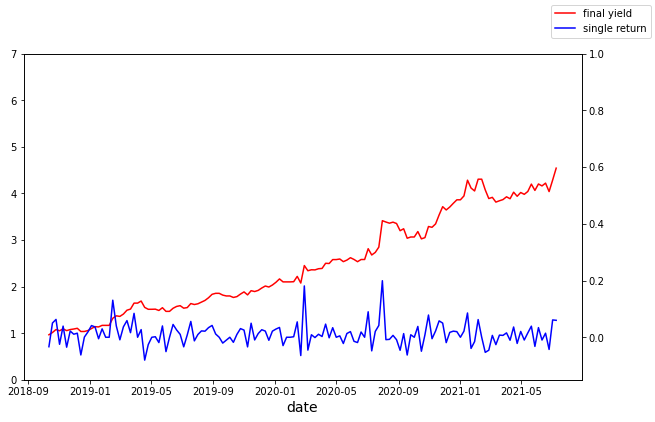

In [81]:
print(f"年化收益率：{round(ret_year*100,4)}%")
print(f"波动率：{round(std_year*100,4)}%")
fig,ax = plt.subplots(figsize=(10,6))

ax.plot(return_line.week_ret,  color="red",label = 'final yield')
ax.set_xlabel("date",fontsize=14)
plt.ylim([0,7])


ax2=ax.twinx()
ax2.plot(return_line['return'], color="blue",label = 'single return')
plt.ylim([-0.15, 1])
fig.legend()
plt.show()

In [22]:
return_line.tail(50)

,week_ret,return
Date,,
2020-07-31,1.015139,0.000974
2020-08-07,1.015261,0.000120
2020-08-14,1.015265,0.000004
2020-08-21,1.015494,0.000225
2020-08-28,1.015478,-0.000016
2020-09-04,1.014985,-0.000485
2020-09-11,1.014919,-0.000065
2020-09-18,1.014361,-0.000550
2020-09-25,1.014404,0.000043
